# Fake News Detection
This notebook compares traditional ML models with BERT for fake news detection using the Fake and Real News dataset from Kaggle.

## Models Compared:
- Logistic Regression
- Random Forest
- Support Vector Classifier (SVC)
- BERT (Hugging Face Transformers)

## Metrics:
- Accuracy
- Precision, Recall, F1-score
- ROC-AUC
- Confusion Matrix

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import torch
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

c:\Users\User\Documents\Portfolio Projects\Learning-Projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

# Load Dataset

In [2]:
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

df_fake['label'] = 0
df_real['label'] = 1

full_df = pd.concat([df_fake, df_real], ignore_index=True)
full_df = full_df.sample(frac=1).reset_index(drop=True)

In [ ]:
# data = df.sample(1000).drop(columns=["title", "subject", "date"])

In [3]:
full_df.head()

,title,text,subject,date,label
0,(VIDEO) MOM OF THE YEAR! WHEN YOUR MOM CATCHES...,,left-news,"Apr 27, 2015",0
1,"EU drugs agency, seeking staff, warns of Brexi...",LONDON (Reuters) - Europe s drugs regulator ha...,worldnews,"October 6, 2017",1
2,Myanmar military appoints general to probe mas...,YANGON (Reuters) - Myanmar s army said on Wedn...,worldnews,"December 20, 2017",1
3,States discussing lawsuit over Trump immigrati...,(Reuters) - A group of state attorneys general...,politicsNews,"January 29, 2017",1
4,Trump’s First Government Agency Visit: CIA,RT . President Donald Trump spoke at CIA Head...,Middle-east,"January 22, 2017",0


In [5]:
full_df.shape

(44898, 5)

# EDA

label
0    23481
1    21417
Name: count, dtype: int64


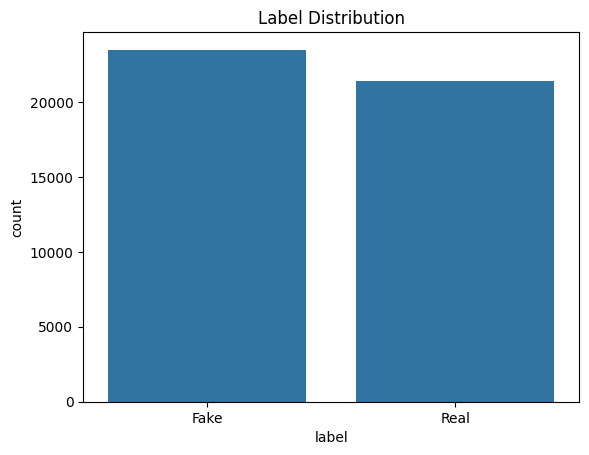

In [6]:
print(full_df['label'].value_counts())
sns.countplot(data=full_df, x='label')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Label Distribution")
plt.show()

# Text Preprocessing

In [7]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

full_df['clean_text'] = full_df['text'].apply(clean_text)

In [8]:
full_df

,title,text,subject,date,label,clean_text
0,(VIDEO) MOM OF THE YEAR! WHEN YOUR MOM CATCHES...,,left-news,"Apr 27, 2015",0,
1,"EU drugs agency, seeking staff, warns of Brexi...",LONDON (Reuters) - Europe s drugs regulator ha...,worldnews,"October 6, 2017",1,london reuters europe drug regulator issued mi...
2,Myanmar military appoints general to probe mas...,YANGON (Reuters) - Myanmar s army said on Wedn...,worldnews,"December 20, 2017",1,yangon reuters myanmar army said wednesday app...
3,States discussing lawsuit over Trump immigrati...,(Reuters) - A group of state attorneys general...,politicsNews,"January 29, 2017",1,reuters group state attorney general discussin...
4,Trump’s First Government Agency Visit: CIA,RT . President Donald Trump spoke at CIA Head...,Middle-east,"January 22, 2017",0,rt president donald trump spoke cia headquarte...
...,...,...,...,...,...,...
44893,AS TRUMP’S POPULARITY SOARS ABROAD…Village In ...,President Donald Trump welcomed India s Prime ...,left-news,"Jun 27, 2017",0,president donald trump welcomed india prime mi...
44894,"CHARLES BARKLEY DROPS TRUTH-BOMB: Blacks, Not ...","It s a dirty, dark secret; I m glad it s comi...",politics,"Sep 7, 2016",0,dirty dark secret glad coming wow guess seeing...
44895,U.S. senators urge NHTSA to accelerate Takata ...,DETROIT/WASHINGTON (Reuters) - U.S. Senators E...,politicsNews,"February 24, 2016",1,detroitwashington reuters u senator edward mar...
44896,Trump Just Threatened To ‘Send In The Feds’ T...,"Holy f*ckballs, it hasn t even been a week sin...",News,"January 24, 2017",0,holy fckballs even week since president asteri...


# Train/Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    full_df['clean_text'], full_df['label'], test_size=0.2, random_state=42
)

# Vectorization with TF-IDF

In [10]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model Training

## Logistic Regression

In [ ]:
# 🤖 Classical Models with Hyperparameter Tuning
models = {
    "Logistic Regression": (LogisticRegression(), {'C': [0.1, 1, 10]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100, 200]}),
    "SVC": (SVC(probability=True), {'C': [0.5, 1, 2]})
}

results = {}
for name, (model, params) in models.items():
    grid = GridSearchCV(model, params, cv=3, scoring='f1', verbose=0)
    grid.fit(X_train_tfidf, y_train)
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)
    y_proba = best_model.predict_proba(X_test_tfidf)[:, 1]
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': grid.best_score_,
        'auc': roc_auc_score(y_test, y_proba)
    }


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4694
           1       0.99      0.99      0.99      4286

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4694
           1       1.00      1.00      1.00      4286

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



# Evaluation

In [ ]:
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()